# NLP Modeling

The "big idea" of modeling is to determine what a document is all about; which words are important or not. The main task is to determine the weight of each word, relative to the document.


## What
- Introducing our _Dramatis Personae_, the characters in our play:
    - `Term frequency` is a direct way to measure what a document is about, but it over-emphasizes common terms. Consider term frequency the baseline, kinda like how median, median, or mode can be baselines. It's at least somewhere to start, even if it's a blunt tool w/ some issues.
        - counting the number of different words
        - challenge: over-emphasizing common terms
        - consider TF kind of like a baseline
    - `TF` = # times a word occurs divided by the total amount of words. 
    - `Bag of words` is a representation of a document as a vector, where the values indicate word frequency. 
        ```
        string = "Mary had a little lamb, little lamb, little lamb."
        string = string.replace(",", "")
        words = string.split()
        bag_of_words = pd.Series(words).value_counts()
        ```
    - Word clouds are a visual bag of words with larger font sizes representing higher term frequency
    - **Inverse Document Frequency** (a measure), `IDF`, tells us how much information a word provides. 
        - A higher IDF means that a word provides more information. That is, it is more relevant within a single document.
        - As the number of documents that a word appears in increases, the IDF value decreases.
        - Example: if "Codeup" appears frequently in every document in a list of documents, then the word doesn't add much new information on any given individual document. ('codeup can be added manually as a stopword).
        - Example: if "scholarship" shows up a whole bunch one one or two documents, but not frequently across the corpus of documents, then we can conclude that that word conveys more meaning.
        - Visual:
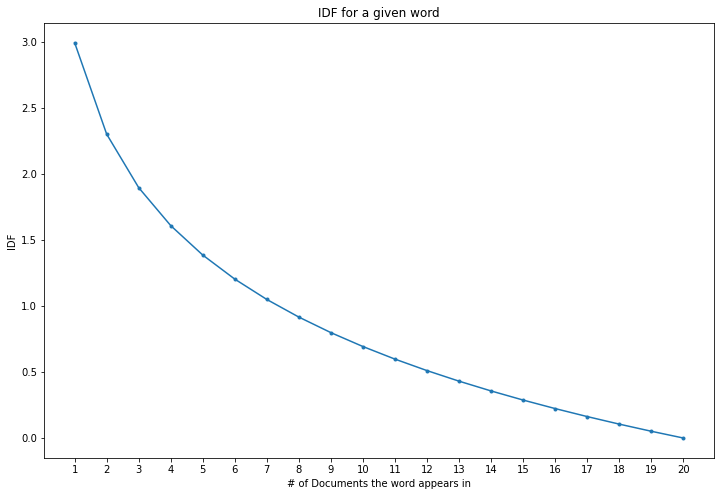
    - `TF-IDF` is the product of `tf * idf`. 


## So What?
- Determining what a document is about is both valuable and challening.
- Term frequency is super sensitive to noise and imprecise.
- TF-IDF is super common and has been used in the majority of text based recommendation systems. See [tf-idf in Wikipedia](https://en.wikipedia.org/wiki/Tf%E2%80%93idf)

## Now What?


In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
import unicodedata
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

In [2]:
df = pd.read_csv("tng.csv")
df.shape

(51988, 3)

In [3]:
df.character.value_counts()

PICARD        10687
RIKER          6109
DATA           5372
LAFORGE        3657
WORF           3277
              ...  
LADY              1
FLETCHER          1
THORNE            1
APPRENTICE        1
SANDERS           1
Name: character, Length: 629, dtype: int64

In [4]:
top_15_characters = df.character.value_counts().index[0:15]

#if char is in list above, then they are top 15
top_15 = df[df.character.isin(top_15_characters)]
top_15 #target var: character

,episode_name,line,character
0,Encounter at Farpoint,Difficult? Simply solve the mystery of Farpoi...,DATA
1,Encounter at Farpoint,As simple as that.,PICARD
2,Encounter at Farpoint,Farpoint Station. Even the name sounds myster...,TROI
3,Encounter at Farpoint,"It's hardly simple, Data, to negotiate a frie...",PICARD
4,Encounter at Farpoint,Inquiry. The word snoop?,DATA
...,...,...,...
51983,All Good Things,Of course. Have a seat.,RIKER
51984,All Good Things,"Would you care to deal, sir?",DATA
51985,All Good Things,"Oh, er, thank you, Mister Data. Actually, I u...",PICARD
51986,All Good Things,You were always welcome.,TROI


In [6]:
ADDITIONAL_STOPWORDS = ['r', 'u', '2', 'ltgt']

def clean(text):
    '''
    This function cleans up text data.
    '''
    
    #lemmatize
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords = nltk.corpus.stopwords.words('english') + ADDITIONAL_STOPWORDS
    
    #normalize
    text = (unicodedata.normalize('NFKD', text)
             .encode('ascii', 'ignore')
             .decode('utf-8', 'ignore')
             .lower())
    words = re.sub(r'[^\w\s]', '', text).split()
    
    return ' '.join([wnl.lemmatize(word) for word in words if word not in stopwords])


In [7]:
df.line = df.line.apply(clean)
df.head()

,episode_name,line,character
0,Encounter at Farpoint,difficult simply solve mystery farpoint station,DATA
1,Encounter at Farpoint,simple,PICARD
2,Encounter at Farpoint,farpoint station even name sound mysterious,TROI
3,Encounter at Farpoint,hardly simple data negotiate friendly agreemen...,PICARD
4,Encounter at Farpoint,inquiry word snoop,DATA


In [8]:
# We'll use this split function later to create in-sample and out-of-sample datasets for modeling
def split(df, stratify_by=None):
    """
    3 way split for train, validate, and test datasets
    To stratify, send in a column name
    """
    
    
    train, test = train_test_split(df, test_size=.2, random_state=123, stratify=df[stratify_by])
    
    train, validate = train_test_split(train, test_size=.3, random_state=123, stratify=train[stratify_by])
    
    return train, validate, test

In [9]:
train, validate, test = split(top_15, 'character')
train.head()

,episode_name,line,character
43382,Second Chances,The transporters are considerably more effici...,DATA
25169,The Loss,I look around me and all I see are surfaces w...,TROI
5207,Coming Of Age,"All right. \nCaptain's log, stardate 41416.2....",WESLEY
40494,Ship in a Bottle,My ship is in danger. It is imperative that I...,PICARD
7290,Conspiracy,"Three, sir. All gathered inside what appears ...",DATA


In [10]:
# Setup our X variables
X_train = train.line
X_validate = validate.line
X_test = test.line

In [11]:
# Setup our y variables
y_train = train.character
y_validate = validate.character
y_test = test.character

In [12]:
X_train.head()

43382     The transporters are considerably more effici...
25169     I look around me and all I see are surfaces w...
5207      All right. \nCaptain's log, stardate 41416.2....
40494     My ship is in danger. It is imperative that I...
7290      Three, sir. All gathered inside what appears ...
Name: line, dtype: object

In [13]:
# Create the tfidf vectorizer object 
#stp 1, this creates a tf-idf values for each word, for each document
#stp 2, enocdes these values so that we can use models that only work on numbers, like classification models
tfidf = TfidfVectorizer() #encoder

# Fit on the training data
tfidf.fit(X_train)

# Use the object
X_train_vectorized = tfidf.transform(X_train)
X_validate_vectorized = tfidf.transform(X_validate)
X_test_vectorized = tfidf.transform(X_test)

In [14]:
#sparse == array w/ lots of 0's
X_train_vectorized 

<21800x13346 sparse matrix of type '<class 'numpy.float64'>'
	with 260544 stored elements in Compressed Sparse Row format>

In [15]:
X_train_vectorized.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [16]:
X_train_vectorized.todense().shape

(21800, 13346)

In [17]:
#w/ vectorized dataset, can use classification tools
#make and fit logistic regression model
lm = LogisticRegression().fit(X_train_vectorized, y_train)

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [18]:
#actual
train = pd.DataFrame(dict(actual=y_train))
validate = pd.DataFrame(dict(actual=y_validate))
test = pd.DataFrame(dict(actual=y_test))

In [19]:
train.head()

,actual
43382,DATA
25169,TROI
5207,WESLEY
40494,PICARD
7290,DATA


In [20]:
#prediction
#use trained model to predict y given those vectorized inputs of X
train['predicted'] = lm.predict(X_train_vectorized)
validate["predicted"] = lm.predict(X_validate_vectorized)
test['predicted'] = lm.predict(X_test_vectorized)

In [21]:
train.head()

,actual,predicted
43382,DATA,DATA
25169,TROI,TROI
5207,WESLEY,PICARD
40494,PICARD,PICARD
7290,DATA,DATA


In [22]:
# Train Accuracy
(train.actual == train.predicted).mean()

0.5438073394495413

In [23]:
#out of sample accuracy
(validate.actual == validate.predicted).mean()

#less, which means model is overfit

0.3987585616438356

In [27]:
#with a trained model, use model to predict the character of any given line
lines = pd.Series([
    "we have a responsibility", 
    "set phasers to stunning", 
    "the warp drive is about to go critical", 
    "What does it mean to be human? I cannot calculate feelings", 
    "Romulan bird of prey decloaking off the port bow",
    "feelings and chocolate"
])

#clean out inputs and lemmatize
lines = lines.apply(clean)

#have to vectorize these inputs if we're going ot use the classification model
lines = tfidf.transform(lines)
lines

<6x13346 sparse matrix of type '<class 'numpy.float64'>'
	with 20 stored elements in Compressed Sparse Row format>

In [28]:
lm.predict(lines)

array(['RIKER', 'RIKER', 'LAFORGE', 'DATA', 'WORF', 'TROI'], dtype=object)

See how well model predicts each character

In [36]:
wesley = train[train.actual == 'WESLEY']

#accuracy
(wesley.actual == wesley.predicted).mean()

0.06204906204906205

In [37]:
data = train[train.actual == 'DATA']

#accuracy
(data.actual == data.predicted).mean()

0.7200797872340425

In [39]:
crusher = train[train.actual == 'CRUSHER']

#accuracy
(crusher.actual == crusher.predicted).mean()

0.284681130834977

In [30]:
from sklearn.metrics import classification_report
print(classification_report(train.actual, train.predicted))

/usr/local/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    COMPUTER       0.97      0.24      0.38       272
     CRUSHER       0.72      0.28      0.41      1521
        DATA       0.62      0.72      0.66      3008
      GUINAN       0.00      0.00      0.00       234
     LAFORGE       0.63      0.48      0.55      2048
     LWAXANA       1.00      0.00      0.01       201
      PICARD       0.49      0.88      0.63      5984
     PULASKI       1.00      0.00      0.01       256
           Q       1.00      0.01      0.01       274
       RIKER       0.51      0.48      0.50      3421
          RO       0.75      0.02      0.03       194
       TASHA       1.00      0.01      0.02       247
        TROI       0.56      0.27      0.36      1612
      WESLEY       0.73      0.06      0.11       693
        WORF       0.61      0.42      0.50      1835

    accuracy                           0.54     21800
   macro avg       0.71      0.26      0.28     21800
weighted avg       0.59   

In [33]:
characters = train.actual.value_counts().index.tolist()

for character in characters:
    print("Character:", character)
    character_lines = train[train.actual == character]
    accuracy = (character_lines.actual == character_lines.predicted).mean()
    print(f'Predicting {character} has {round(accuracy, 2)}')

Character: PICARD
Predicting PICARD has 0.88
Character: RIKER
Predicting RIKER has 0.48
Character: DATA
Predicting DATA has 0.72
Character: LAFORGE
Predicting LAFORGE has 0.48
Character: WORF
Predicting WORF has 0.42
Character: TROI
Predicting TROI has 0.27
Character: CRUSHER
Predicting CRUSHER has 0.28
Character: WESLEY
Predicting WESLEY has 0.06
Character: Q
Predicting Q has 0.01
Character: COMPUTER
Predicting COMPUTER has 0.24
Character: PULASKI
Predicting PULASKI has 0.0
Character: TASHA
Predicting TASHA has 0.01
Character: GUINAN
Predicting GUINAN has 0.0
Character: LWAXANA
Predicting LWAXANA has 0.0
Character: RO
Predicting RO has 0.02


In [35]:
#dataset is faily imbalanced
train.actual.value_counts(), train.shape

(PICARD      5984
 RIKER       3421
 DATA        3008
 LAFORGE     2048
 WORF        1835
 TROI        1612
 CRUSHER     1521
 WESLEY       693
 Q            274
 COMPUTER     272
 PULASKI      256
 TASHA        247
 GUINAN       234
 LWAXANA      201
 RO           194
 Name: actual, dtype: int64,
 (21800, 2))